<a href="https://colab.research.google.com/github/Ilya-Lopatin/Oscillator-with-friction.-Laplace-transform.-Runge-Kutta-method/blob/main/Laplace_actually.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import sympy

from scipy import integrate

sympy.init_printing()

Рассмотрим систему "осцилятор с вязким трением". Динамика этой системы задается следующим уравнением:
$$
f(t) - k  x(t) - γ x'(t) = m x'' (t)
$$
где $k, γ, m$ -- постоянные. Начальные условия будем считать: $x(0) = 0, ~ x'(0) = 0$.

Рассмотрим поведение системы под действием силы, являющиеся последовательностью прямоугольных импульсов величины $A$, длиной $t_0$ и задержкой между импульсами $Δ t$.

In [3]:
def F( A, t0, dt, t ) :
    k = math.floor ( t / (t0 + dt) )
    if t < k * (t0 + dt) + t0 :
        return A
    else :
        return 0 

#right side for R-K
def f( xv_vec, t , A, t0, dt , g, k, m) :
    x, v = xv_vec
    return np.array ( [ v, (F(A, t0, dt, t) - g * v - k * x ) / m ] )

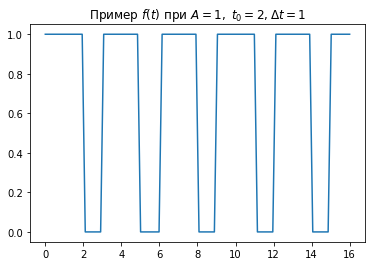

In [4]:
t_f = np.linspace (0, 16, 100)

f_arr = [ F( 1, 2, 1, t_f[i]) for i in  range(100) ]

plt.plot( t_f, f_arr )
plt.title("Пример $f(t)$ при $A=1, ~ t_0 = 2, \Delta t = 1 $")
plt.show()

Заметим, что $f(t)$ можно представить как:
$$
f(t) =  \left\{ \begin{aligned}
                &A, ∃ k \in \mathbb{N}_0: k(t_0 + Δ t) \leq t < k(t_0 + Δ t) + t_0 \\
                &0, \text{ иначе}
        \end{aligned} \right.
$$

Используя операторный метод в линейном приближении:
$$
\mathcal{L} [ f(t) ] (s) = \int_{0}^{∞} e^{-st} f(t) dt = A \sum_{k=0}^{\infty} \left( e^{ -sk(t_0 + \delta t) } - e^{-sk(t_0 + \delta t) - s t_0} \right) = \frac{A ( 1 - e^{s t_0})}{s(1 - e^{-s(t_0 + \delta t)})} 
$$
Пррименяя разложение по Тейлору до второго порядка:
$$
\mathcal{L} [f] (s) \sim \frac{ \tilde{A} }{s}
$$
где $\tilde{A} = \frac{1}{1 + \Delta t / t_0 }$

Тогда:
$$
\mathcal{L} [x] (s) = \frac{ \tilde{A} }{ s ( m s^2 + γ s + k ) } = \tilde{A} \left( \frac{r}{ s \left( \left( T s + \sigma \right)^2 + (1 - \sigma^2)  \right)   }  \right) 
$$
где:
$$
r = \frac{1}{k}, ~  T = \sqrt{ \frac{m}{k} }, ~ \sigma =  \frac{ γ }{ 2 \sqrt{mk} }
$$

Дальше приведено исследование этой системы.

1) Строится численное решение пакетным методом scipy.integrate.odeint()

2) Также с помошью библиотеки scipy построено обратное преобразование Лапласса и затем полученные траектории сравниваются с первым методом

In [5]:
def packet_sol ( sharp_time, A, t0, dt, g, k, m ):
    sol = integrate.odeint(f, [0, 0], sharp_time , args=(A, t0, dt , g, k, m) )
    return sol[:,0]


In [6]:
t, s = sympy.symbols('t, s')

def symbol_L ( f ) :
    return sympy.laplace_transform (f, t, s, noconds=True )

def symbol_invL(F):
    return sympy.inverse_laplace_transform(F, s, t)

exp = sympy.exp
sin = sympy.sin
cos = sympy.cos
re = sympy.re 
i = sympy.I


r = sympy.symbols( 'r' , real=True, positive=True )
T = sympy.symbols( 'T' , real=True, positive=True )
xi = sympy.symbols( 'xi' , real=True, positive=True )
om = sympy.Symbol('omega', real=True, positive=True ) 

G_pos =  r / ( s * ( (T*s + xi)**2 + om**2  )  )
G_neg =  r / ( s * ( (T*s + xi)**2 - om**2  )  )
G_netr =  r / ( s * ( (T*s + 1)**2   )  )


In [7]:
g_pos = symbol_invL ( G_pos )
g_neg = symbol_invL ( G_neg )
g_netr = symbol_invL ( G_netr )

In [8]:
g_pos = g_pos * ( om - i * xi )**2 * ( om + i * xi )**2
g_pos

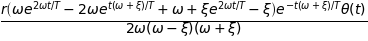

In [9]:
g_neg

In [10]:
g_netr

In [11]:
def get_value_Laplace ( num_t, A, t0, dt, m, k, g ) :
    global g_pos, g_neg, g_netr
    tildeA = A / ( 1 + dt / t0 )
    num_r = 1 / k
    num_T = np.sqrt( m / k )
    num_xi = g / ( 2 * np.sqrt( m *k ) )
    num_om, res = 0, 0
    if np.abs ( num_xi - 1) < 1e-6 :
        res = g_netr.subs( [ ( r, num_r ), ( xi, num_xi ), ( T, num_T ) , 
                            (om , 0 ), (t, num_t)  ] )
    if 1 - num_xi**2  > 1e-6 :
        num_om = np.sqrt( 1 - num_xi**2 )
        res = g_pos.subs( [ ( r, num_r ), ( xi, num_xi ), ( T, num_T ) , 
                           (om , num_om ), (t, num_t)  ] )
    if  1 - num_xi**2  < -1e-6 :
         num_om = np.sqrt(  num_xi**2 - 1 )
         res = g_neg.subs( [ ( r, num_r ), ( xi, num_xi ), ( T, num_T ) , 
                            (om , num_om ), (t, num_t)  ] )
    return tildeA * res.evalf()     

In [12]:
def get_asympt ( A, k, dt, t0 ) :
    return A / ( k * ( 1 + dt / t0 ) )

def strr ( x ):
    return str(round(x, 2))    


def draw_trajectory( A, t0, dt, g, k, m, T_max, n_node, flag_num, flag_th ) :
    time_ex_sol = np.linspace(0.001, T_max, int( 10 * T_max ) )
    fig, ax = plt.subplots()
    if flag_num :
        time_packet_sol = np.linspace(0, T_max, int(n_node) )
        x_ps = packet_sol ( time_packet_sol , A ,t0, dt, g, k, m )
        ax.plot ( time_packet_sol, x_ps, color = 'b', label = 'packet sol' )
    if flag_th :    
        x_th = [  get_value_Laplace ( t , A, t0, dt, k, m, g ) 
                    for t in time_ex_sol]
        ax.plot (time_ex_sol, x_th, color = 'g', label = 'Laplace sol')
    asympt = get_asympt ( A, k, dt, t0 )
    x_as = [ asympt for i in range ( 10 * T_max ) ]
    ax.plot( time_ex_sol, x_as, '--k' , label = 'asympt: $x =$' + 
            str( round(asympt , 2)) )

    sigma =  g / ( 2 * np.sqrt(m*k) )

    if (1 - sigma) > 1e-3 :
        v_up = [ asympt * np.exp( - g / ( 2 * m) * itt ) + asympt 
                    for itt in time_ex_sol ]
        ax.plot ( time_ex_sol, v_up, '--k', label = 'UP_bound: $x(t)=$'+
                 strr(asympt)+'exp('+strr(- g / ( 2 * m)) + 't)+'+strr(asympt))
        v_down = [ -asympt * np.exp( - g / ( 2 * m) * itt ) + 
                  asympt for itt in time_ex_sol ]
        ax.plot ( time_ex_sol, v_down, '--k', label = 'Lower_bound: $x(t)=-$'+
                 strr(asympt)+'exp('+strr(- g / ( 2 * m)) + 't)+'+strr(asympt))
        ax.set_title('$ \sigma < 1$', fontsize = 16)

    if ( sigma - 1 )  > 1e-3 :
        ax.set_title('$\sigma > 1 $',  fontsize = 16)
    if np.abs(1 - sigma) < 1e-3 :
        ax.set_title('$ \sigma = 1 $',  fontsize = 16) 


    ax.grid()

    ax.legend(shadow = True, fontsize = 14)
    

    fig.set_figwidth(10)
    fig.set_figheight(10) 
    
    plt.show()

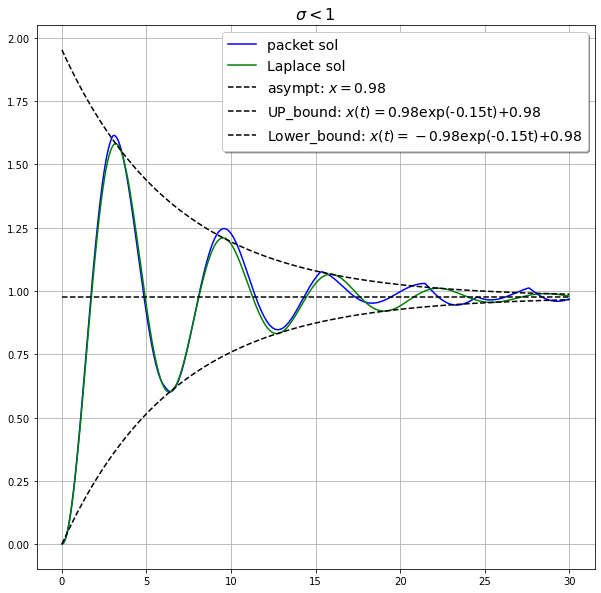

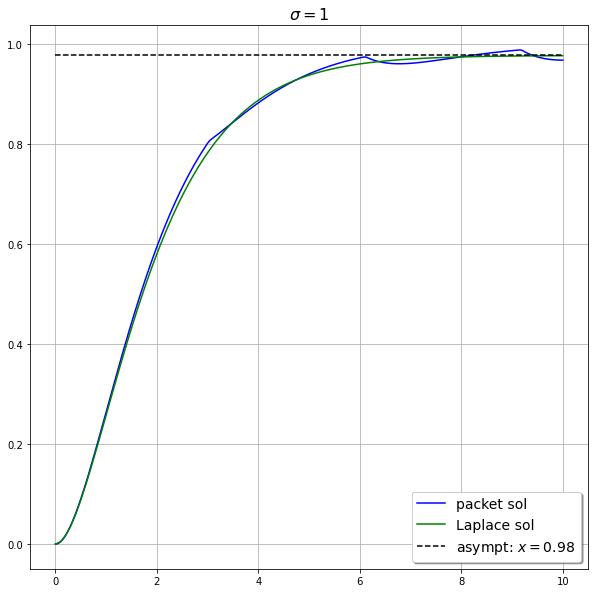

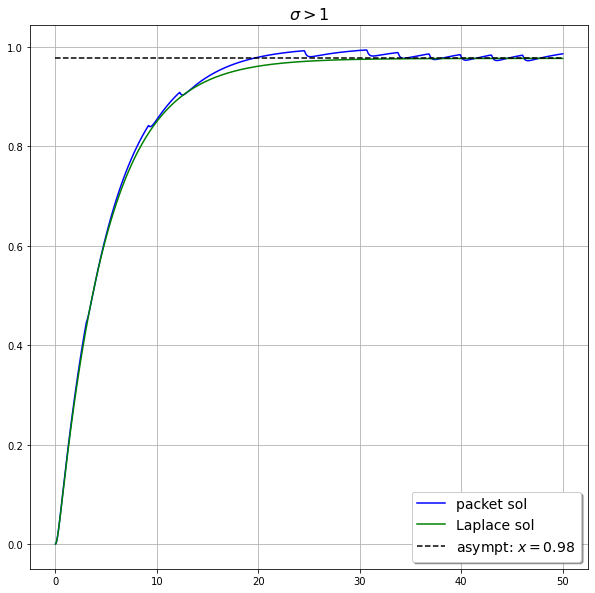

In [13]:
A = 1
t0 , dt = 3, 0.073
k = 1
m = 1
g = 0.3

draw_trajectory( A, t0, dt, g, k, m, 30, 1e7, True, True ) 

g = 2

draw_trajectory( A, t0, dt, g, k, m, 10, 1e7, True, True )

g = 5

draw_trajectory( A, t0, dt, g, k, m, 50, 5*1e7, True, True )